# COVID19 - April 2020 Forecast
### A simple LSTM to predict time series

Disclaimer: The purpose of this notebook is to implement a basic LSTM network on the COVID19 dataset as a basis for further analysis. Since I'm not using any external dataset, the predictions will most likely be inaccurate.

For the multivariate type of LSTM the credits go to this very useful blogpost: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import datetime

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


/kaggle/input/covid19-global-forecasting-week-2/train.csv
/kaggle/input/covid19-global-forecasting-week-2/submission.csv
/kaggle/input/covid19-global-forecasting-week-2/test.csv


## Exploration

In [2]:
train_df = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-2/train.csv')

In [3]:
display(train_df.head())
display(train_df.info())

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19698 entries, 0 to 19697
Data columns (total 6 columns):
Id                19698 non-null int64
Province_State    8375 non-null object
Country_Region    19698 non-null object
Date              19698 non-null object
ConfirmedCases    19698 non-null float64
Fatalities        19698 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 923.5+ KB


None

In [4]:
print('We have', len(train_df.Country_Region.unique()), 'countries/regions in the dataset.')
print('We have', len(train_df.Province_State.unique()), 'provinces/states in the dataset.')

We have 173 countries/regions in the dataset.
We have 126 provinces/states in the dataset.


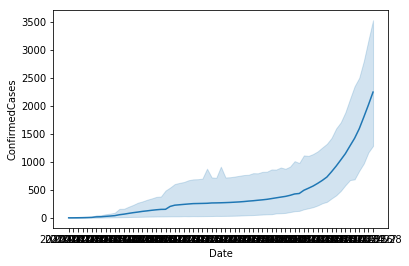

In [5]:
timetrend_sick = sns.lineplot(train_df['Date'], train_df['ConfirmedCases'])

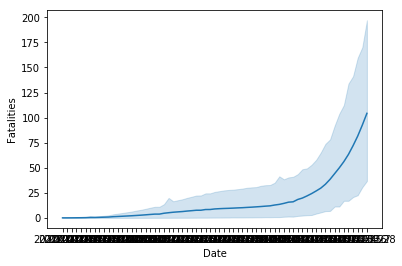

In [6]:
timetrend_deceased = sns.lineplot(train_df['Date'], train_df['Fatalities'])

In [7]:
# Add a new column to be able to uniquely distinguish countries/regions

train_df['UniqueRegion'] = np.where(train_df['Province_State'].isna(), train_df['Country_Region'], train_df['Country_Region'] + ' - ' + train_df['Province_State'])

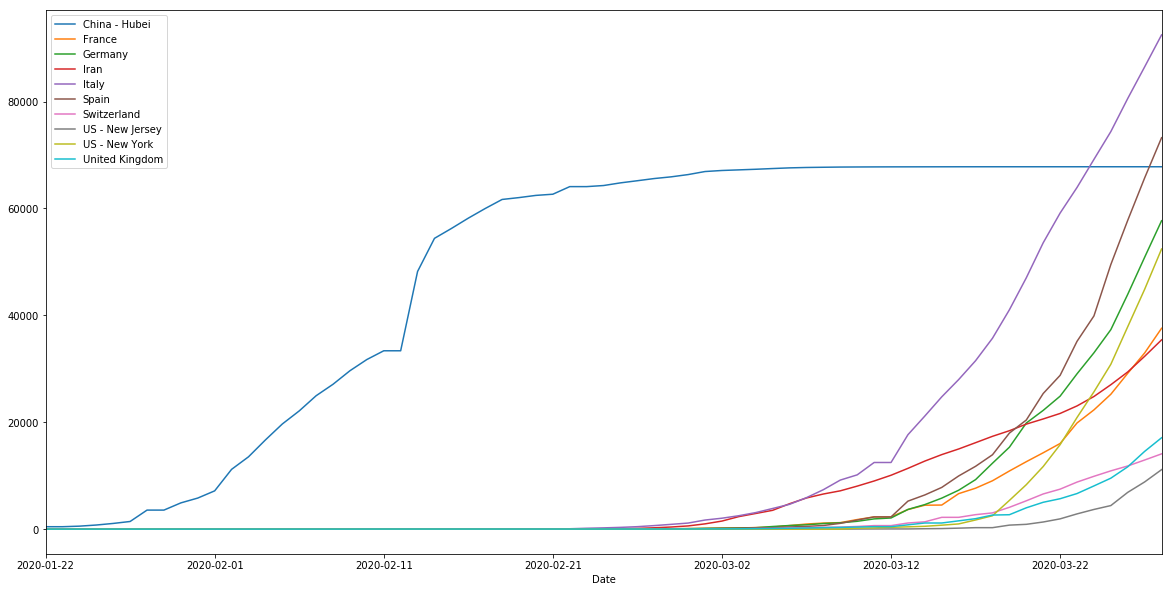

In [8]:
# Show trends for 10 countries with most confirmed cases

top10_most_cases = train_df.loc[train_df['Date'] == train_df['Date'].max()][['UniqueRegion','ConfirmedCases']].sort_values(by='ConfirmedCases', ascending=False).head(10)
top10_most_cases_df = train_df.loc[train_df['UniqueRegion'].isin(top10_most_cases['UniqueRegion'].values)]

main_df = pd.DataFrame()

for i, top10_country in enumerate (top10_most_cases_df['UniqueRegion'].unique()):
    if i == 0:
        main_df = top10_most_cases_df.loc[top10_most_cases_df['UniqueRegion'] == top10_country][['Date', 'ConfirmedCases']].sort_values(by='Date')
        main_df = main_df.rename({'ConfirmedCases': top10_country}, axis='columns')

    else:
        temp_df = top10_most_cases_df.loc[top10_most_cases_df['UniqueRegion'] == top10_country][['Date', 'ConfirmedCases']]
        temp_df = temp_df.rename({'ConfirmedCases': top10_country}, axis='columns')
        main_df = pd.merge(main_df, temp_df, on=['Date'])

main_df = main_df.set_index('Date')
main_df.plot(figsize=(20,10))

## Transformation & Pre-processing

The original plan was to use the number of sick per day as one of the input features in the model. I ended up abandoning this idea due to time constraints but I'm leaving the code here for possible future reference.

In [9]:
# Calculate number of new sick per day

unique_regions = np.sort(train_df['UniqueRegion'].unique())
train_df['SickPerDay'] = 0

baseline_length = len(train_df.loc[train_df['UniqueRegion'] == 'Afghanistan']) # Country chosen arbitrarily

for unique_region in unique_regions:
    len_country = len(train_df.loc[train_df['UniqueRegion'] == unique_region])
    len_diffs = len(train_df.loc[train_df['UniqueRegion'] == unique_region]['ConfirmedCases'].diff())
    if len_country > baseline_length or len_diffs > baseline_length:
        raise NameError('Too many rows for country {}'.format(unique_region))
    train_df['SickPerDay'].loc[(train_df['UniqueRegion'] == unique_region)] = train_df.loc[train_df['UniqueRegion'] == unique_region]['ConfirmedCases'].diff()
    
train_df['SickPerDay'] = train_df['SickPerDay'].fillna(0)

# Show an example
display(train_df.loc[train_df['UniqueRegion'] == 'Czechia'].tail())

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,UniqueRegion,SickPerDay
6092,9063,NaN,Czechia,2020-03-24,1394.0,3.0,Czechia,158.0
6093,9064,NaN,Czechia,2020-03-25,1654.0,6.0,Czechia,260.0
6094,9065,NaN,Czechia,2020-03-26,1925.0,9.0,Czechia,271.0
6095,9066,NaN,Czechia,2020-03-27,2279.0,9.0,Czechia,354.0
6096,9067,NaN,Czechia,2020-03-28,2631.0,11.0,Czechia,352.0


The idea is to train the LSTM on all countries at once, so we need to transform the dataset a bit and create a separate column for each country/region.

In [10]:
# Transform main data into a horizontal dataframe

def transform_horizontally(input_df, value_column):

    horizontal_df = pd.DataFrame()

    for i, uniqueRegion in enumerate (unique_regions):
        if i == 0:
            horizontal_df = input_df.loc[input_df['UniqueRegion'] == uniqueRegion][['Date', value_column]].sort_values(by='Date')
            horizontal_df = horizontal_df.rename({value_column: uniqueRegion}, axis='columns')

        else:
            temp_df = input_df.loc[train_df['UniqueRegion'] == uniqueRegion][['Date', value_column]]
            temp_df = temp_df.rename({value_column: uniqueRegion}, axis='columns')
            horizontal_df = pd.merge(horizontal_df, temp_df, on=['Date'])
            
    return horizontal_df

In [11]:
confirmed_horizontal_df = transform_horizontally(train_df, 'ConfirmedCases').sort_values(by='Date')
fatalities_horizontal_df = transform_horizontally(train_df, 'Fatalities').sort_values(by='Date')


display(confirmed_horizontal_df.head())
display(confirmed_horizontal_df.shape)

display(fatalities_horizontal_df.head())
display(fatalities_horizontal_df.shape)

,Date,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia - Australian Capital Territory,...,United Kingdom - Channel Islands,United Kingdom - Gibraltar,United Kingdom - Isle of Man,United Kingdom - Montserrat,Uruguay,Uzbekistan,Venezuela,Vietnam,Zambia,Zimbabwe
0,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
2,2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0


(67, 295)

,Date,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia - Australian Capital Territory,...,United Kingdom - Channel Islands,United Kingdom - Gibraltar,United Kingdom - Isle of Man,United Kingdom - Montserrat,Uruguay,Uzbekistan,Venezuela,Vietnam,Zambia,Zimbabwe
0,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(67, 295)

In [12]:
# Convert dataframes into numpy arrays

np_confirmed = confirmed_horizontal_df.drop(columns=['Date']).to_numpy()
np_fatalities = fatalities_horizontal_df.drop(columns=['Date']).to_numpy()

In [13]:
# Scale the values (better performance of LSTM)

scaler = MinMaxScaler(feature_range = (0, 1))

np_confirmed_scaled = scaler.fit_transform(np_confirmed)
np_fatalities_scaled = scaler.fit_transform(np_confirmed)

In [15]:
# Split a multivariate sequence into samples
# Credits to: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting

def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [16]:
n_steps_in = 30
n_steps_out = 1

X_confirmed, y_confirmed = split_sequences(np_confirmed_scaled, n_steps_in, n_steps_out)
X_fatalities, y_fatalities = split_sequences(np_fatalities_scaled, n_steps_in, n_steps_out)

In [19]:
assert X_confirmed.shape == X_fatalities.shape
assert y_confirmed.shape == y_fatalities.shape

n_features = X_confirmed.shape[2]

## Training the LSTM Model

### Confirmed Cases

In [20]:
# Define model for confirmed cases

model_confirmed = Sequential()
model_confirmed.add(LSTM(1000, activation='relu', input_shape=(n_steps_in, n_features)))
model_confirmed.add(RepeatVector(n_steps_out))
model_confirmed.add(LSTM(2000, activation='relu', return_sequences=True))
model_confirmed.add(Dropout(0.2))
model_confirmed.add(LSTM(2000, activation='relu', return_sequences=True))
model_confirmed.add(Dropout(0.2))
model_confirmed.add(LSTM(2000, activation='relu', return_sequences=True))
model_confirmed.add(Dropout(0.2))
model_confirmed.add(LSTM(1000, activation='relu', return_sequences=True))
model_confirmed.add(TimeDistributed(Dense(n_features)))
model_confirmed.compile(optimizer='adam', loss='mse')

model_confirmed.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1000)              5180000   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 1000)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 2000)           24008000  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 2000)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 2000)           32008000  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 2000)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 2000)          

In [21]:
model_confirmed.fit(X_confirmed, y_confirmed, epochs=300)

Epoch 1/300
37/37 [==============================] - 7s 185ms/step - loss: 0.2039
Epoch 2/300
37/37 [==============================] - 3s 91ms/step - loss: 0.2027
Epoch 3/300
37/37 [==============================] - 3s 94ms/step - loss: 0.2013
Epoch 4/300
37/37 [==============================] - 3s 94ms/step - loss: 0.1995
Epoch 5/300
37/37 [==============================] - 4s 100ms/step - loss: 0.1968
Epoch 6/300
37/37 [==============================] - 4s 102ms/step - loss: 0.1876
Epoch 7/300
37/37 [==============================] - 4s 102ms/step - loss: 3459.1041
Epoch 8/300
37/37 [==============================] - 3s 93ms/step - loss: 0.2001
Epoch 9/300
37/37 [==============================] - 4s 96ms/step - loss: 0.1894
Epoch 10/300
37/37 [==============================] - 4s 97ms/step - loss: 0.1720
Epoch 11/300
37/37 [==============================] - 3s 93ms/step - loss: 0.4186
Epoch 12/300
37/37 [==============================] - 3s 92ms/step - loss: 0.1744
Epoch 13/300
37/37

37/37 [==============================] - 3s 89ms/step - loss: 0.0076
Epoch 101/300
37/37 [==============================] - 3s 90ms/step - loss: 0.0092
Epoch 102/300
37/37 [==============================] - 3s 89ms/step - loss: 0.0061
Epoch 103/300
37/37 [==============================] - 3s 92ms/step - loss: 0.0060
Epoch 104/300
37/37 [==============================] - 3s 88ms/step - loss: 0.0072
Epoch 105/300
37/37 [==============================] - 3s 91ms/step - loss: 0.0062
Epoch 106/300
37/37 [==============================] - 3s 89ms/step - loss: 0.0048
Epoch 107/300
37/37 [==============================] - 4s 95ms/step - loss: 0.0051
Epoch 108/300
37/37 [==============================] - 4s 99ms/step - loss: 0.0050
Epoch 109/300
37/37 [==============================] - 3s 93ms/step - loss: 0.0054
Epoch 110/300
37/37 [==============================] - 3s 92ms/step - loss: 0.0050
Epoch 111/300
37/37 [==============================] - 3s 93ms/step - loss: 0.0056
Epoch 112/300
37/3

37/37 [==============================] - 4s 97ms/step - loss: 0.0032
Epoch 199/300
37/37 [==============================] - 3s 93ms/step - loss: 0.0040
Epoch 200/300
37/37 [==============================] - 4s 98ms/step - loss: 0.0033
Epoch 201/300
37/37 [==============================] - 3s 91ms/step - loss: 0.0034
Epoch 202/300
37/37 [==============================] - 3s 94ms/step - loss: 0.0037
Epoch 203/300
37/37 [==============================] - 4s 99ms/step - loss: 0.0032
Epoch 204/300
37/37 [==============================] - 4s 99ms/step - loss: 0.0031
Epoch 205/300
37/37 [==============================] - 3s 91ms/step - loss: 0.0035
Epoch 206/300
37/37 [==============================] - 3s 91ms/step - loss: 0.0038
Epoch 207/300
37/37 [==============================] - 3s 89ms/step - loss: 0.0032
Epoch 208/300
37/37 [==============================] - 3s 92ms/step - loss: 0.0032
Epoch 209/300
37/37 [==============================] - 3s 86ms/step - loss: 0.0037
Epoch 210/300
37/3

37/37 [==============================] - 3s 91ms/step - loss: 0.0035
Epoch 297/300
37/37 [==============================] - 3s 87ms/step - loss: 0.0042
Epoch 298/300
37/37 [==============================] - 3s 90ms/step - loss: 0.0032
Epoch 299/300
37/37 [==============================] - 3s 90ms/step - loss: 0.0036
Epoch 300/300
37/37 [==============================] - 3s 92ms/step - loss: 0.0035


In [23]:
X_confirmed_pred = np_confirmed_scaled[-n_steps_in-1:-n_steps_out].reshape((1, n_steps_in, n_features))
y_confirmed_pred = model_confirmed.predict(X_confirmed_pred)

In [24]:
# Display targets and predictions side by side

comparison_df = pd.DataFrame()
comparison_df['Target'] = list(np_confirmed[-1])
comparison_df['Prediction'] = [int(x) for x in scaler.inverse_transform(y_confirmed_pred[0])[0].astype(int)]
comparison_df

,Target,Prediction
0,110.0,107
1,197.0,176
2,454.0,427
3,308.0,282
4,5.0,4
...,...,...
289,104.0,100
290,119.0,113
291,174.0,172
292,28.0,26


### Fatalities

In [25]:
# Define model for confirmed cases

model_fatalities = Sequential()
model_fatalities.add(LSTM(1000, activation='relu', input_shape=(n_steps_in, n_features)))
model_fatalities.add(RepeatVector(n_steps_out))
model_fatalities.add(LSTM(2000, activation='relu', return_sequences=True))
model_fatalities.add(Dropout(0.2))
model_fatalities.add(LSTM(2000, activation='relu', return_sequences=True))
model_fatalities.add(Dropout(0.2))
model_fatalities.add(LSTM(2000, activation='relu', return_sequences=True))
model_fatalities.add(Dropout(0.2))
model_fatalities.add(LSTM(1000, activation='relu', return_sequences=True))
model_fatalities.add(TimeDistributed(Dense(n_features)))
model_fatalities.compile(optimizer='adam', loss='mse')

model_fatalities.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 1000)              5180000   
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 1, 1000)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 1, 2000)           24008000  
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 2000)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 1, 2000)           32008000  
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 2000)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 1, 2000)          

In [26]:
model_fatalities.fit(X_fatalities, y_fatalities, epochs=300)

Epoch 1/300
37/37 [==============================] - 6s 175ms/step - loss: 0.2039
Epoch 2/300
37/37 [==============================] - 3s 90ms/step - loss: 0.2024
Epoch 3/300
37/37 [==============================] - 3s 91ms/step - loss: 0.2008
Epoch 4/300
37/37 [==============================] - 3s 90ms/step - loss: 0.1988
Epoch 5/300
37/37 [==============================] - 3s 86ms/step - loss: 0.1956
Epoch 6/300
37/37 [==============================] - 3s 92ms/step - loss: 0.2443
Epoch 7/300
37/37 [==============================] - 3s 90ms/step - loss: 0.1786
Epoch 8/300
37/37 [==============================] - 3s 90ms/step - loss: 0.1867
Epoch 9/300
37/37 [==============================] - 3s 89ms/step - loss: 0.1845
Epoch 10/300
37/37 [==============================] - 3s 88ms/step - loss: 0.1704
Epoch 11/300
37/37 [==============================] - 3s 90ms/step - loss: 0.7698
Epoch 12/300
37/37 [==============================] - 3s 88ms/step - loss: 0.1616
Epoch 13/300
37/37 [====

Epoch 101/300
37/37 [==============================] - 3s 93ms/step - loss: 0.0042
Epoch 102/300
37/37 [==============================] - 3s 92ms/step - loss: 0.0046
Epoch 103/300
37/37 [==============================] - 4s 99ms/step - loss: 0.0044
Epoch 104/300
37/37 [==============================] - 4s 95ms/step - loss: 0.0053
Epoch 105/300
37/37 [==============================] - 4s 98ms/step - loss: 0.0061
Epoch 106/300
37/37 [==============================] - 4s 99ms/step - loss: 0.0049
Epoch 107/300
37/37 [==============================] - 3s 91ms/step - loss: 0.0062
Epoch 108/300
37/37 [==============================] - 3s 93ms/step - loss: 0.0040
Epoch 109/300
37/37 [==============================] - 3s 92ms/step - loss: 0.0059
Epoch 110/300
37/37 [==============================] - 3s 87ms/step - loss: 0.0041
Epoch 111/300
37/37 [==============================] - 3s 86ms/step - loss: 0.0050
Epoch 112/300
37/37 [==============================] - 3s 92ms/step - loss: 0.0090
Epoc

37/37 [==============================] - 3s 88ms/step - loss: 0.0037
Epoch 200/300
37/37 [==============================] - 3s 90ms/step - loss: 0.0028
Epoch 201/300
37/37 [==============================] - 4s 100ms/step - loss: 0.0029
Epoch 202/300
37/37 [==============================] - 4s 103ms/step - loss: 0.0033
Epoch 203/300
37/37 [==============================] - 3s 92ms/step - loss: 0.0027
Epoch 204/300
37/37 [==============================] - 3s 90ms/step - loss: 0.0030
Epoch 205/300
37/37 [==============================] - 3s 90ms/step - loss: 0.0031
Epoch 206/300
37/37 [==============================] - 3s 89ms/step - loss: 0.0030
Epoch 207/300
37/37 [==============================] - 3s 91ms/step - loss: 0.0026
Epoch 208/300
37/37 [==============================] - 3s 89ms/step - loss: 0.0030
Epoch 209/300
37/37 [==============================] - 3s 92ms/step - loss: 0.0027
Epoch 210/300
37/37 [==============================] - 4s 105ms/step - loss: 0.0029
Epoch 211/300
3

37/37 [==============================] - 3s 91ms/step - loss: 0.0025
Epoch 298/300
37/37 [==============================] - 3s 93ms/step - loss: 0.0021
Epoch 299/300
37/37 [==============================] - 7s 198ms/step - loss: 0.0027
Epoch 300/300
37/37 [==============================] - 11s 294ms/step - loss: 0.0022


In [28]:
X_fatalities_pred = np_fatalities_scaled[-n_steps_in-1:-n_steps_out].reshape((1, n_steps_in, n_features))
y_fatalities_pred = model_fatalities.predict(X_fatalities_pred)

In [29]:
# Display targets and predictions side by side

comparison_df = pd.DataFrame()
comparison_df['Target'] = list(np_fatalities[-1])
comparison_df['Prediction'] = [int(x) for x in scaler.inverse_transform(y_fatalities_pred[0])[0].astype(int)]
comparison_df

,Target,Prediction
0,4.0,118
1,10.0,214
2,29.0,446
3,3.0,317
4,0.0,4
...,...,...
289,2.0,106
290,2.0,121
291,0.0,178
292,0.0,31


## Prediction

In [30]:
# Read test set

test_df = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-2/test.csv')
test_df['UniqueRegion'] = np.where(test_df['Province_State'].isna(), test_df['Country_Region'], test_df['Country_Region'] + ' - ' + test_df['Province_State'])

In [41]:
# Predict for the necessary number of days

num_days_to_predict = datetime.datetime.strptime(test_df['Date'].max(), '%Y-%m-%d') - datetime.datetime.strptime(train_df['Date'].max(), '%Y-%m-%d')
num_days_to_predict.days

# Copy the train set for the purposes of prediction
X_test_confirmed = np_confirmed_scaled.copy()
X_test_fatalities = np_fatalities_scaled.copy()

def predict_for_test_set(model, X_test):
    for day in range(num_days_to_predict.days):
        X_pred_temp = X_test[-n_steps_in:].reshape((1, n_steps_in, n_features))
        y_pred_temp = model.predict(X_pred_temp)
        X_test = np.append(X_test, y_pred_temp[0], axis=0)
    return X_test

X_test_confirmed = predict_for_test_set(model_confirmed, X_test_confirmed)
X_test_fatalities = predict_for_test_set(model_fatalities, X_test_fatalities)

assert X_test_confirmed.shape == X_test_fatalities.shape
print('We have', X_test_confirmed.shape[0], 'days after predicting.')

We have 100 days after predicting.


In [51]:
# Copy predicted values into test dataframe

test_final = pd.merge(test_df, train_df, how='left', on=['Date', 'UniqueRegion'])
X_test_confirmed_inversed = scaler.inverse_transform(X_test_confirmed)
X_test_fatalities_inversed = scaler.inverse_transform(X_test_fatalities)
dummy_df = pd.DataFrame(test_final.loc[(test_final['UniqueRegion'] == unique_regions[0]) & ((test_final['ConfirmedCases'].isna()) | (test_final['Fatalities'].isna()))].sort_values(by='Date')['Date'])

for i, unique_region in enumerate(unique_regions):
    df_temp = dummy_df.copy()
    assert len(X_test_confirmed_inversed[-num_days_to_predict.days:,i]) == len(df_temp)
    assert len(X_test_fatalities_inversed[-num_days_to_predict.days:,i]) == len(df_temp)
    df_temp['ConfirmedCasesTemp'] = X_test_confirmed_inversed[-num_days_to_predict.days:,i]
    df_temp['FatalitiesTemp'] = X_test_fatalities_inversed[-num_days_to_predict.days:,i]
    df_temp['UniqueRegion'] = unique_region
    test_final = pd.merge(test_final, df_temp, how='left', on=['Date', 'UniqueRegion'])
    try:
        test_final['ConfirmedCases'] = np.where((test_final['UniqueRegion'] == unique_region) & test_final['ConfirmedCases'].isna(), test_final['ConfirmedCasesTemp'], test_final['ConfirmedCases'])
        test_final['Fatalities'] = np.where((test_final['UniqueRegion'] == unique_region) & test_final['Fatalities'].isna(), test_final['FatalitiesTemp'], test_final['Fatalities'])
    except:
        test_final['ConfirmedCases'] = np.where((test_final['UniqueRegion'] == unique_region) & test_final['ConfirmedCases'].isna(), None, test_final['ConfirmedCases'])
        test_final['Fatalities'] = np.where((test_final['UniqueRegion'] == unique_region) & test_final['Fatalities'].isna(), None, test_final['Fatalities'])
        
    #display(test_final.head(50))
    if 'ConfirmedCasesTemp' in test_final.columns:
        test_final = test_final.drop(columns=['ConfirmedCasesTemp'])
    if 'FatalitiesTemp' in test_final.columns:
        test_final = test_final.drop(columns=['FatalitiesTemp'])
        


assert not test_final['ConfirmedCases'].isnull().values.any()
assert not test_final['Fatalities'].isnull().values.any()

In [52]:
test_final['ConfirmedCases'] = test_final['ConfirmedCases'].astype(int)
test_final['Fatalities'] = test_final['Fatalities'].astype(int)

In [53]:
test_final.loc[test_final['UniqueRegion'] == 'Czechia']

,ForecastId,Province_State_x,Country_Region_x,Date,UniqueRegion,Id,Province_State_y,Country_Region_y,ConfirmedCases,Fatalities,SickPerDay
3870,3871,NaN,Czechia,2020-03-19,Czechia,9058.0,NaN,Czechia,694,0,230.0
3871,3872,NaN,Czechia,2020-03-20,Czechia,9059.0,NaN,Czechia,833,0,139.0
3872,3873,NaN,Czechia,2020-03-21,Czechia,9060.0,NaN,Czechia,995,0,162.0
3873,3874,NaN,Czechia,2020-03-22,Czechia,9061.0,NaN,Czechia,1120,1,125.0
3874,3875,NaN,Czechia,2020-03-23,Czechia,9062.0,NaN,Czechia,1236,1,116.0
3875,3876,NaN,Czechia,2020-03-24,Czechia,9063.0,NaN,Czechia,1394,3,158.0
3876,3877,NaN,Czechia,2020-03-25,Czechia,9064.0,NaN,Czechia,1654,6,260.0
3877,3878,NaN,Czechia,2020-03-26,Czechia,9065.0,NaN,Czechia,1925,9,271.0
3878,3879,NaN,Czechia,2020-03-27,Czechia,9066.0,NaN,Czechia,2279,9,354.0
3879,3880,NaN,Czechia,2020-03-28,Czechia,9067.0,NaN,Czechia,2631,11,352.0


In [62]:
sub_sample_df = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-2/submission.csv')
sub_sample_df

,ForecastId,ConfirmedCases,Fatalities
0,1,1,1
1,2,1,1
2,3,1,1
3,4,1,1
4,5,1,1
...,...,...,...
12637,12638,1,1
12638,12639,1,1
12639,12640,1,1
12640,12641,1,1


In [64]:
submission_df = test_final[['ForecastId', 'ConfirmedCases', 'Fatalities']]
submission_df.to_csv('submission.csv')

NameError: name 'submission' is not defined